# Understanding Hired Rides in NYC



## Project Setup

In [5]:
# All import statements needed for the project

import os
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import re
import gc
from datetime import datetime, timedelta
import numpy as np
import math
import glob
import scipy
from scipy.stats import t
import seaborn as sns

In [7]:
# Contents Needed

TLC_URL = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "data/taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "data/weather"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [9]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones

In [13]:
def load_taxi_zones(shapefile):
    """
    Load taxi zones shapefile using geopandas.

    Args:
        shapefile (str): Path to the taxi zones shapefile.

    Returns:
        GeoDataFrame: The loaded GeoDataFrame containing taxi zones data.
    """
    # Read the shapefile using geopandas
    geofile = gpd.read_file(shapefile)

    # Return the loaded GeoDataFrame
    return geofile

In [15]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    """
    Find the geographical coordinates of a taxi zone by its ID.

    Args:
        zone_loc_id (int): The ID of the taxi zone.
        loaded_taxi_zones (GeoDataFrame): GeoDataFrame containing taxi zones data.

    Returns:
        tuple or None: The latitude and longitude as a tuple, or None if not found.
    """
    # Filter the GeoDataFrame for the specified taxi zone ID
    zone = loaded_taxi_zones[loaded_taxi_zones['LocationID'] == zone_loc_id]

    # Check if the specified zone ID exists
    if zone.empty:
        return None

    # Compute the centroid of the matched zone's geometry
    centroid = zone.geometry.centroid.iloc[0]

    # Return the latitude (y) and longitude (x) as a tuple
    return (centroid.y, centroid.x)

### Calculate Sample Size

In [18]:
def calculate_sample_size(population: int, confidence_level: float = 0.95, margin_of_error: float = 0.05, p: float = 0.5) -> int:
    """
    Calculate the sample size using Cochran's formula.

    Args:
        population (int): The total number of data points in the population.
        confidence_level (float): The confidence level (default is 0.95).
        margin_of_error (float): The margin of error (default is 0.05).
        p (float): The estimated proportion of the population.

    Returns:
        int: The calculated sample size.
    """
    # Map confidence levels to their corresponding z-scores
    z = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}.get(confidence_level, 1.96)

    # Compute the initial sample size using Cochran's formula
    numerator = (z ** 2) * p * (1 - p)
    denominator = margin_of_error ** 2
    sample_size = numerator / denominator

    # Adjust sample size for finite populations
    if population > 0:
        adjusted_sample_size = sample_size / (1 + (sample_size - 1) / population)
    else:
        adjusted_sample_size = sample_size

    return int(np.ceil(adjusted_sample_size))

### Common Functions

In [21]:
def get_all_urls_from_tlc_page(taxi_page):
    """
    Fetches all URLs from a given webpage.

    Args:
        taxi_page (str): URL of the webpage to scrape.

    Returns:
        list: List of all URLs found on the webpage.
    """
    try:
        # Send a GET request to the page
        response = requests.get(taxi_page)
        response.raise_for_status()  # Raise an HTTPError for bad responses
    except requests.exceptions.RequestException as e:
        # Handle exceptions and provide an informative error message
        raise Exception(f"Failed to access the URL: {taxi_page}. Error: {e}")

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all anchor tags with href attributes
    links = soup.find_all("a", href=True)

    # Extract and return all href attributes
    all_urls = [link["href"] for link in links]

    return all_urls

In [23]:
def filter_parquet_urls(all_urls):
    """
    Filter and return only URLs pointing to Parquet files.

    Args:
        all_urls (list): List of all URLs to filter.

    Returns:
        list: List of URLs pointing to Parquet files.
    """
    # Initialize an empty list to store Parquet file URLs
    parquet_urls = []

    # Iterate through each URL in the input list
    for url in all_urls:
        url = url.strip()
        
        # Use regex to ensure matching even with query parameters
        if re.search(r"\.parquet(\?.*)?$", url):
            parquet_urls.append(url)

    return parquet_urls

### Process Taxi Data

In [26]:
def get_and_clean_taxi_month(url: str) -> pd.DataFrame:
    """
    Downloads, processes, and saves Yellow Taxi dataset for a given month.

    Args:
        url (str): URL of the Yellow Taxi Parquet file.

    Returns:
        pd.DataFrame: Sampled and processed DataFrame, or an empty DataFrame if the file is invalid.
    """
    save_dir = "processed_data/yellow_taxi"
    os.makedirs(save_dir, exist_ok=True)  # Ensure the save directory exists

    file_name = url.split("/")[-1]
    local_file_path = os.path.join(save_dir, file_name)

    # Step 1: Download the file if it doesn't exist
    if not os.path.exists(local_file_path):
        print(f"Downloading file: {url}")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(local_file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024 * 1024):  # 1MB chunks
                    if chunk:
                        f.write(chunk)
            print(f"Downloaded and saved file: {local_file_path}")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {url}: {e}")
            return pd.DataFrame()

    # Step 2: Load the Parquet file
    try:
        data = pd.read_parquet(local_file_path)
        if data.empty or not data.notna().any().any():
            print(f"File {local_file_path} is empty or contains only NaN values.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error reading Parquet file {local_file_path}: {e}")
        return pd.DataFrame()

    # Step 3: Sample the dataset
    population = len(data)
    if population == 0:
        print(f"File {local_file_path} contains no data.")
        return pd.DataFrame()
    sample_size = calculate_sample_size(population, p=0.5)
    sampled_data = data.sample(n=sample_size, random_state=42) if population > sample_size else data

    # Step 4: Save the processed data
    processed_file_path = os.path.join(save_dir, f"sampled_{file_name}")
    sampled_data.to_parquet(processed_file_path)
    print(f"Processed data saved to: {processed_file_path}")

    return sampled_data

In [28]:
def get_and_clean_taxi_data(parquet_urls):
    """
    Process multiple Parquet files of taxi data by filtering, cleaning, and combining them into a single DataFrame.

    Args:
        parquet_urls (list): List of Parquet file URLs to process.

    Returns:
        pd.DataFrame: Combined DataFrame containing all cleaned taxi data.
    """
    all_taxi_dataframes = []  # Initialize a list to store cleaned DataFrames

    # Step 1: Filter URLs using regex
    yellow_taxi_pattern = re.compile(r"yellow_tripdata_(202[0-4]-(0[1-9]|1[0-2]))\.parquet")
    yellow_taxi_urls = [url for url in parquet_urls if yellow_taxi_pattern.search(url)]
    if not yellow_taxi_urls:
        print("No URLs matched the Yellow Taxi data pattern.")
        return pd.DataFrame()

    print(f"Processing {len(yellow_taxi_urls)} files matching the pattern.")

    # Step 2: Process each filtered URL
    for url in yellow_taxi_urls:
        dataframe = get_and_clean_taxi_month(url)
        if not dataframe.empty:
            if "Airport_fee" in dataframe.columns:
                dataframe = dataframe.rename(columns={"Airport_fee": "airport_fee"})  # Avoid inplace=True

            # Inline logic to clean numeric and datetime columns
            for col in dataframe.columns:
                if pd.api.types.is_numeric_dtype(dataframe[col]):
                    dataframe[col] = dataframe[col].fillna(0)  # Avoid inplace=True
                elif pd.api.types.is_datetime64_any_dtype(dataframe[col]) and dataframe[col].isna().all():
                    dataframe = dataframe.drop(columns=[col])  # Avoid inplace=True

            all_taxi_dataframes.append(dataframe)

    # Step 3: Handle column inconsistencies and NaN issues
    if all_taxi_dataframes:
        # Remove all-NaN columns
        all_taxi_dataframes = [df.dropna(how='all', axis=1) for df in all_taxi_dataframes]

        # Ensure common columns across all DataFrames
        common_columns = list(set.intersection(*[set(df.columns) for df in all_taxi_dataframes]))  # Convert set to list
        all_taxi_dataframes = [df[common_columns] for df in all_taxi_dataframes]

        # Concatenate all cleaned DataFrames
        taxi_data = pd.concat(all_taxi_dataframes, ignore_index=True)
        print(f"Successfully combined {len(all_taxi_dataframes)} DataFrames.")
    else:
        print("No valid DataFrames to combine.")
        taxi_data = pd.DataFrame()

    return taxi_data

In [30]:
def get_taxi_data():
    """
    Main function to fetch, process, and clean all taxi data from a predefined URL.

    Returns:
        pd.DataFrame: Combined and cleaned taxi data.
    """
    # Fetch all URLs from the TLC page
    all_urls = get_all_urls_from_tlc_page(TLC_URL)

    # Filter the URLs to get only those pointing to Parquet files
    all_parquet_urls = filter_parquet_urls(all_urls)

    # Process the filtered Parquet files and combine them
    taxi_data = get_and_clean_taxi_data(all_parquet_urls)

    return taxi_data

In [32]:
# Fetch and process all taxi data
taxi_data = get_taxi_data()

Processing 57 files matching the pattern.
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-01.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-02.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-03.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-04.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-05.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-06.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-07.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-08.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-09.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2023-01.parquet
Processed data saved to: processed_dat

In [34]:
taxi_data.head()

,store_and_fwd_flag,extra,VendorID,PULocationID,total_amount,improvement_surcharge,congestion_surcharge,payment_type,tpep_dropoff_datetime,DOLocationID,fare_amount,tip_amount,trip_distance,tpep_pickup_datetime,mta_tax,tolls_amount,passenger_count,RatecodeID
0,N,0.0,2,132,90.96,1.0,2.5,1,2024-01-20 14:03:25,233,70.0,8.27,17.14,2024-01-20 13:31:30,0.5,6.94,2.0,2.0
1,N,1.0,2,163,22.50,1.0,2.5,1,2024-01-18 22:03:21,75,13.5,4.00,2.49,2024-01-18 21:52:46,0.5,0.00,1.0,1.0
2,N,1.0,2,127,12.50,1.0,0.0,2,2024-01-01 03:50:47,20,10.0,0.00,1.84,2024-01-01 03:43:58,0.5,0.00,2.0,1.0
3,N,3.5,1,186,33.95,1.0,2.5,1,2024-01-19 22:50:12,263,23.3,5.65,3.60,2024-01-19 22:20:12,0.5,0.00,1.0,1.0
4,N,1.0,2,238,6.20,1.0,0.0,2,2024-01-06 22:43:24,238,3.7,0.00,0.04,2024-01-06 22:41:50,0.5,0.00,1.0,1.0


In [36]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21941 entries, 0 to 21940
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   store_and_fwd_flag     20730 non-null  object        
 1   extra                  21941 non-null  float64       
 2   VendorID               21941 non-null  int64         
 3   PULocationID           21941 non-null  int64         
 4   total_amount           21941 non-null  float64       
 5   improvement_surcharge  21941 non-null  float64       
 6   congestion_surcharge   21941 non-null  float64       
 7   payment_type           21941 non-null  int64         
 8   tpep_dropoff_datetime  21941 non-null  datetime64[us]
 9   DOLocationID           21941 non-null  int64         
 10  fare_amount            21941 non-null  float64       
 11  tip_amount             21941 non-null  float64       
 12  trip_distance          21941 non-null  float64       
 13  t

In [38]:
taxi_data.describe()

,extra,VendorID,PULocationID,total_amount,improvement_surcharge,congestion_surcharge,payment_type,tpep_dropoff_datetime,DOLocationID,fare_amount,tip_amount,trip_distance,tpep_pickup_datetime,mta_tax,tolls_amount,passenger_count,RatecodeID
count,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941,21941.000000,21941.000000,21941.000000,21941.000000,21941,21941.000000,21941.000000,21941.000000,21941.000000
mean,1.196216,1.719429,165.091199,22.713167,0.550052,2.141083,1.182854,2022-05-17 01:13:18.223371,161.639898,15.659498,2.704115,3.292919,2022-05-17 00:57:00.007338,0.488059,0.453536,1.321407,1.398888
min,-7.500000,1.000000,4.000000,-251.000000,-1.000000,-2.500000,0.000000,2009-01-01 01:11:20,1.000000,-250.000000,-0.130000,0.000000,2009-01-01 01:11:17,-0.500000,-34.200000,0.000000,0.000000
25%,0.000000,1.000000,132.000000,12.770000,0.300000,2.500000,1.000000,2021-03-10 07:26:47,107.000000,7.200000,0.000000,1.050000,2021-03-10 07:21:05,0.500000,0.000000,1.000000,1.000000
50%,0.500000,2.000000,162.000000,17.150000,0.300000,2.500000,1.000000,2022-05-16 18:18:08,162.000000,11.000000,2.150000,1.800000,2022-05-16 18:05:44,0.500000,0.000000,1.000000,1.000000
75%,2.500000,2.000000,234.000000,24.840000,1.000000,2.500000,1.000000,2023-07-25 16:18:31,234.000000,17.700000,3.450000,3.310000,2023-07-25 16:04:59,0.500000,0.000000,1.000000,1.000000
max,11.750000,6.000000,265.000000,289.350000,1.000000,2.500000,4.000000,2024-09-30 23:56:08,265.000000,278.800000,51.150000,67.900000,2024-09-30 23:52:50,0.500000,57.050000,6.000000,99.000000
std,1.515058,0.492829,65.707289,19.218796,0.355888,0.918538,0.569043,NaN,70.845724,15.476094,3.294636,4.276046,NaN,0.098153,1.913663,1.003036,6.209745


### Processing Uber Data

In [66]:
def get_and_clean_uber_month(url):
    save_dir = "processed_data/hvhf"

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Extract file name and define local path
    file_name = url.split("/")[-1]
    local_file_path = os.path.join(save_dir, file_name)

    # Download the file if not already downloaded
    if not os.path.exists(local_file_path):
        print(f"Downloading HVHF file: {url} ...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(local_file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024 * 1024):  # 1MB chunks
                    if chunk:
                        f.write(chunk)
            print(f"File saved to: {local_file_path}")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {url}: {e}")
            return pd.DataFrame()  # Return an empty DataFrame if download fails
    else:
        print(f"Loading file from local storage: {local_file_path}")

    # Load the dataset
    try:
        data = pd.read_parquet(local_file_path)
    except Exception as e:
        print(f"Error reading Parquet file {local_file_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if reading fails

    # Determine population size
    population = len(data)
    print(f"Population size: {population}")

    # Calculate sample size (using p = 0.5 for Yellow Taxi data)
    sample_size = calculate_sample_size(population, p = 0.4)
    print(f"Calculated sample size: {sample_size}")

    # Sample the dataset
    sampled_data = data.sample(n=sample_size, random_state=42) if population > sample_size else data

    # Save the sampled dataset
    processed_file_path = os.path.join(save_dir, f"sampled_{file_name}")
    sampled_data.to_parquet(processed_file_path)
    print(f"Processed file saved to: {processed_file_path}")

    return sampled_data

In [68]:
# def get_and_clean_uber_data(parquet_urls):
    """
    Process multiple Parquet files of Uber data by filtering, cleaning, and combining them into a single DataFrame.

    Args:
        parquet_urls (list): List of Parquet file URLs to process.

    Returns:
        pd.DataFrame: Combined DataFrame containing all cleaned Uber data.
    """
    all_uber_dataframes = []

    # Filter URLs of HVHF data
    hvfhv_pattern = re.compile(r"fhvhv_tripdata_(2020-(0[1-9]|1[0-2])|2021-(0[1-9]|1[0-2])|2024-(0[1-9]))\.parquet")
    hvfhv_urls = [url for url in parquet_urls if hvfhv_pattern.search(url)]

    for url in hvfhv_urls:
        # Clean data through function defined before
        dataframe = get_and_clean_uber_month(url)

        # Skip empty dataframes
        if not dataframe.empty:
            all_uber_dataframes.append(dataframe)

    # Combine all non-empty HVHF data
    uber_data = pd.concat(all_uber_dataframes, ignore_index=True)
    return uber_data

In [172]:
def get_and_clean_uber_data(parquet_urls):
    """
    Process multiple Parquet files of Uber data by filtering, cleaning, and combining them into a single DataFrame.

    Args:
        parquet_urls (list): List of Parquet file URLs to process.

    Returns:
        pd.DataFrame: Combined DataFrame containing all cleaned Uber data.
    """
    all_uber_dataframes = []

    # Filter URLs of HVHF data
    hvfhv_pattern = re.compile(r"fhvhv_tripdata_(2020-(0[1-9]|1[0-2])|2021-(0[1-9]|1[0-2])|2022-(0[1-9]|1[0-2])|2023-(0[1-9]|1[0-2])|2024-(0[1-9]))\.parquet")
    hvfhv_urls = [url for url in parquet_urls if hvfhv_pattern.search(url)]

    for url in hvfhv_urls:
        dataframe = get_and_clean_uber_month(url)

        if not dataframe.empty:
            dataframe = dataframe.dropna(axis=1, how='all')
            all_uber_dataframes.append(dataframe)

    uber_data = pd.concat(all_uber_dataframes, ignore_index=True)
    return uber_data

In [174]:
def load_and_clean_uber_data(uber_data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and process Uber HVHF data, including filtering by license, adding coordinates,
    retaining required columns, and normalizing data.

    Args:
        uber_data (pd.DataFrame): A DataFrame containing combined HVHF data.

    Returns:
        pd.DataFrame: A cleaned and filtered DataFrame with necessary columns and normalized values.
    """
    uber_data['hvfhs_license_num'] = uber_data['hvfhs_license_num'].astype(str)

    # Filter rows where 'hvfhs_license_num' is 'HV0003' (Uber)
    uber_only_data = uber_data[uber_data['hvfhs_license_num'] == 'HV0003'].copy()
    return uber_only_data

In [176]:
def get_uber_data() -> pd.DataFrame:
    """
    Retrieve, filter, process, and clean Uber HVHF data from the TLC data page.

    Returns:
        pd.DataFrame: A cleaned and processed DataFrame containing Uber HVHF trip data.
    """
    all_urls = get_all_urls_from_tlc_page(TLC_URL)
    all_parquet_urls = filter_parquet_urls(all_urls)
    u_data = get_and_clean_uber_data(all_parquet_urls)
    uber_data = load_and_clean_uber_data(u_data)
    return uber_data

In [178]:
uber_data = get_uber_data()

Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-01.parquet
Population size: 19663930
Calculated sample size: 369
Processed file saved to: processed_data/hvhf/sampled_fhvhv_tripdata_2024-01.parquet
Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-02.parquet
Population size: 19359148
Calculated sample size: 369
Processed file saved to: processed_data/hvhf/sampled_fhvhv_tripdata_2024-02.parquet
Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-03.parquet
Population size: 21280788
Calculated sample size: 369
Processed file saved to: processed_data/hvhf/sampled_fhvhv_tripdata_2024-03.parquet
Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-04.parquet
Population size: 19733038
Calculated sample size: 369
Processed file saved to: processed_data/hvhf/sampled_fhvhv_tripdata_2024-04.parquet
Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-05.parquet
Population size: 20704538
Ca

In [182]:
uber_data.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
1,HV0003,B03404,B03404,2024-01-26 07:58:05,2024-01-26 08:06:17,2024-01-26 08:07:17,2024-01-26 08:35:38,85,77,4.29,...,2.44,0.00,0.0,0.00,24.88,N,N,N,N,N
2,HV0003,B03404,B03404,2024-01-19 02:12:56,2024-01-19 02:16:27,2024-01-19 02:17:05,2024-01-19 02:29:12,220,243,2.55,...,1.34,0.00,0.0,0.00,10.19,N,N,N,N,N
3,HV0003,B03404,B03404,2024-01-21 01:39:37,2024-01-21 01:43:40,2024-01-21 01:44:00,2024-01-21 02:08:30,164,80,6.37,...,2.18,2.75,0.0,3.01,23.00,N,N,N,N,N
5,HV0003,B03404,B03404,2024-01-20 12:56:18,2024-01-20 12:58:28,2024-01-20 12:58:40,2024-01-20 13:15:42,161,246,1.99,...,1.68,2.75,0.0,0.00,12.47,N,N,N,N,N
8,HV0003,B03404,B03404,2024-01-02 08:22:37,2024-01-02 08:40:29,2024-01-02 08:40:48,2024-01-02 08:54:28,77,177,2.23,...,1.43,0.00,0.0,0.00,10.64,N,N,N,N,N


In [184]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15275 entries, 1 to 21032
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   hvfhs_license_num     15275 non-null  object        
 1   dispatching_base_num  15275 non-null  object        
 2   originating_base_num  15272 non-null  object        
 3   request_datetime      15275 non-null  datetime64[us]
 4   on_scene_datetime     15275 non-null  datetime64[us]
 5   pickup_datetime       15275 non-null  datetime64[us]
 6   dropoff_datetime      15275 non-null  datetime64[us]
 7   PULocationID          15275 non-null  int64         
 8   DOLocationID          15275 non-null  int64         
 9   trip_miles            15275 non-null  float64       
 10  trip_time             15275 non-null  int64         
 11  base_passenger_fare   15275 non-null  float64       
 12  tolls                 15275 non-null  float64       
 13  bcf                  

In [186]:
uber_data.describe()

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay
count,15275,15275,15275,15275,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,15275.000000,11322.000000,15275.000000,15275.000000
mean,2022-05-21 07:15:54.778396,2022-05-21 07:19:31.325433,2022-05-21 07:20:38.988216,2022-05-21 07:39:10.189983,138.130016,141.351817,4.853648,1111.447201,22.638122,1.040667,0.671023,1.903266,1.023928,0.189785,0.910115,18.100601
min,2020-01-01 02:45:20,2020-01-01 02:48:30,2020-01-01 02:50:21,2020-01-01 03:12:01,3.000000,1.000000,0.000000,47.000000,-24.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021-03-13 12:41:52.500000,2021-03-13 12:45:10,2021-03-13 12:45:34,2021-03-13 13:14:58,74.000000,74.000000,1.585000,570.000000,10.680000,0.000000,0.290000,0.890000,0.000000,0.000000,0.000000,8.520000
50%,2022-05-21 16:47:14,2022-05-21 16:52:32,2022-05-21 16:53:04,2022-05-21 17:20:04,140.000000,141.000000,2.940000,906.000000,17.160000,0.000000,0.480000,1.450000,0.000000,0.000000,0.000000,13.810000
75%,2023-07-28 13:04:37,2023-07-28 13:07:21,2023-07-28 13:08:26,2023-07-28 13:27:44.500000,211.000000,216.000000,5.980000,1423.000000,27.655000,0.000000,0.810000,2.380000,2.750000,0.000000,0.000000,22.580000
max,2024-09-30 21:32:29,2024-09-30 21:35:32,2024-09-30 21:35:40,2024-09-30 21:50:59,263.000000,265.000000,123.170000,9710.000000,347.900000,43.890000,10.440000,30.880000,2.750000,5.000000,58.790000,261.440000
std,NaN,NaN,NaN,NaN,75.497167,77.984987,5.673163,783.984970,19.530094,3.806885,0.626772,1.606217,1.325067,0.665196,2.920948,14.871282


### Processing Weather Data

In [322]:
def get_all_weather_csvs(directory):
    """
    Reads all CSV files from the specified directory.

    Args:
        directory (str): The directory path containing the weather data CSV files.

    Returns:
        list: A list of pandas DataFrames, each corresponding to a CSV file.
    """
    files = glob.glob(os.path.join(directory, '*.csv'))

    csv_files = []
    for file in files:
        # Read each CSV file and append it to the list
        df = pd.read_csv(file, low_memory=False)
        csv_files.append(df)
    return csv_files

In [408]:
def clean_hourly_weather_data(csv_file):
    columns = ["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]
    hourly_data = csv_file[columns].copy()

    # Convert DATE columns to datetime type
    hourly_data["DATE"] = pd.to_datetime(hourly_data["DATE"], errors="coerce")

    # Clean up HourlyPrecipitation columns
    hourly_data["HourlyPrecipitation"] = hourly_data["HourlyPrecipitation"].replace("T", 0.01)  # 将 T 替换为 0.01
    hourly_data["HourlyPrecipitation"] = hourly_data["HourlyPrecipitation"].replace(0, 0.01)    # 将 0 替换为 0.01
    hourly_data["HourlyPrecipitation"] = pd.to_numeric(hourly_data["HourlyPrecipitation"], errors="coerce").fillna(0)  # 其他空值填充为 0

    # Clean up HourlyWindSpeed ​​columns
    hourly_data["HourlyWindSpeed"] = pd.to_numeric(hourly_data["HourlyWindSpeed"], errors="coerce").fillna(0)

    return hourly_data

In [459]:
def clean_daily_weather_data(csv_file):
    """
    Cleans and extracts necessary columns for daily weather data.

    Args:
        csv_file (DataFrame): A pandas DataFrame containing raw weather data.

    Returns:
        DataFrame: A cleaned DataFrame containing only required daily weather data.
    """
    columns = ["DATE", "DailyPrecipitation", "DailyAverageWindSpeed", "DailySnowfall"]
    daily_data = csv_file[columns].copy()

    # Convert DATE columns to datetime type
    daily_data["DATE"] = pd.to_datetime(daily_data["DATE"], errors="coerce")

    # Clean up DailyPrecipitation columns
    daily_data["DailyPrecipitation"] = daily_data["DailyPrecipitation"].replace("T", 0.01) 
    daily_data["DailyPrecipitation"] = daily_data["DailyPrecipitation"].replace(0, 0.01)
    daily_data["DailyPrecipitation"] = pd.to_numeric(daily_data["DailyPrecipitation"], errors="coerce").fillna(0)

    # Clean up DailySnowfall columns
    daily_data["DailySnowfall"] = daily_data["DailySnowfall"].replace("T", 0.01) 
    daily_data["DailySnowfall"] = daily_data["DailySnowfall"].replace(0, 0.01) 
    daily_data["DailySnowfall"] = pd.to_numeric(daily_data["DailySnowfall"], errors="coerce").fillna(0)

    # Clean up DailyAverageWindSpeed ​​columns
    daily_data["DailyAverageWindSpeed"] = pd.to_numeric(daily_data["DailyAverageWindSpeed"], errors="coerce").fillna(0)

    return daily_data

In [475]:
def load_and_clean_weather_data():
    """
    Loads and cleans weather data for both hourly and daily observations.

    Returns:
        tuple: Two pandas DataFrames containing cleaned hourly and daily weather data.
    """
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)

    hourly_dataframes = []
    daily_dataframes = []

    for csv_file in weather_csv_files:
        # Clean and extract relevant data
        hourly_dataframe = clean_hourly_weather_data(csv_file)  # 确保 DATE 转换在这里完成
        daily_dataframe = clean_daily_weather_data(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)

    # Combine data into single DataFrames
    hourly_data = pd.concat(hourly_dataframes, ignore_index=True)
    daily_data = pd.concat(daily_dataframes, ignore_index=True)

    return hourly_data, daily_data

In [477]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [478]:
hourly_weather_data.head()

,DATE,HourlyPrecipitation,HourlyWindSpeed
0,2020-01-01 00:51:00,0.0,8.0
1,2020-01-01 01:51:00,0.0,8.0
2,2020-01-01 02:51:00,0.0,14.0
3,2020-01-01 03:51:00,0.0,11.0
4,2020-01-01 04:51:00,0.0,6.0


In [479]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 56098 non-null  datetime64[ns]
 1   HourlyPrecipitation  56098 non-null  float64       
 2   HourlyWindSpeed      56098 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.3 MB


In [483]:
hourly_weather_data.describe()

,DATE,HourlyPrecipitation,HourlyWindSpeed
count,56098,56098.000000,56098.000000
mean,2022-05-29 21:14:19.618881024,0.010948,4.537238
min,2020-01-01 00:51:00,0.000000,0.000000
25%,2021-03-18 19:01:45,0.000000,0.000000
50%,2022-05-28 01:21:00,0.000000,5.000000
75%,2023-08-15 05:39:00,0.000000,7.000000
max,2024-10-22 18:51:00,3.470000,2237.000000
std,NaN,0.055967,13.883208


In [485]:
daily_weather_data.head()

,DATE,DailyPrecipitation,DailyAverageWindSpeed,DailySnowfall
0,2020-01-01 00:51:00,0.0,0.0,0.0
1,2020-01-01 01:51:00,0.0,0.0,0.0
2,2020-01-01 02:51:00,0.0,0.0,0.0
3,2020-01-01 03:51:00,0.0,0.0,0.0
4,2020-01-01 04:51:00,0.0,0.0,0.0


In [487]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   56098 non-null  datetime64[ns]
 1   DailyPrecipitation     56098 non-null  float64       
 2   DailyAverageWindSpeed  56098 non-null  float64       
 3   DailySnowfall          56098 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.7 MB


In [489]:
daily_weather_data.describe()

,DATE,DailyPrecipitation,DailyAverageWindSpeed,DailySnowfall
count,56098,56098.000000,56098.000000,56098.000000
mean,2022-05-29 21:14:19.618881024,0.004475,0.151276,0.001234
min,2020-01-01 00:51:00,0.000000,0.000000,0.000000
25%,2021-03-18 19:01:45,0.000000,0.000000,0.000000
50%,2022-05-28 01:21:00,0.000000,0.000000,0.000000
75%,2023-08-15 05:39:00,0.000000,0.000000,0.000000
max,2024-10-22 18:51:00,7.130000,14.200000,14.800000
std,NaN,0.077361,0.948191,0.087521


## Part 2: Storing Cleaned Data

In [499]:
engine = db.create_engine(DATABASE_URL)

In [501]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    date_time TEXT PRIMARY KEY,
    temperature FLOAT,
    precipitation FLOAT,
    wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    date TEXT PRIMARY KEY,
    avg_temperature FLOAT,
    total_precipitation FLOAT,
    total_snowfall FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    trip_id INTEGER PRIMARY KEY,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
    trip_distance FLOAT,
    fare_amount FLOAT,
    tip_amount FLOAT,
    total_amount FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    trip_id INTEGER PRIMARY KEY,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
FLOAT    trip_distance FLOAT,
    fare_amount FLOAT,
    tip_amount FLOAT,
    total_amount FLOAT
);
"""

In [503]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [505]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

In [507]:
def write_dataframes_to_table(table_to_df_dict):
    with engine.connect() as connection:
        for table_name, dataframe in table_to_df_dict.items():
            try:
                dataframe.to_sql(table_name, con=connection, if_exists="replace", index=False)
                print(f"Data written to table: {table_name}")
            except Exception as e:
                print(f"Failed to write to table {table_name}: {e}")

In [509]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [511]:
write_dataframes_to_table(map_table_name_to_dataframe)

Data written to table: taxi_trips
Data written to table: uber_trips
Data written to table: hourly_weather
Data written to table: daily_weather


## Part 3: Understanding the Data

In [514]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    filepath = os.path.join(QUERY_DIRECTORY, outfile)
    with open(filepath, "w") as f:
        f.write(query)
    print(f"Query written to file: {filepath}")

### Query 1

In [517]:
QUERY_1_FILENAME = "Query 1: Popular taxi hour.sql"

QUERY_1 = """
SELECT strftime('%H', tpep_pickup_datetime) AS hour,
       COUNT(*) AS ride_count
FROM taxi_trips
WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY hour
ORDER BY ride_count DESC;
"""

In [519]:
# execute query either via pandas
df_query_1 = pd.read_sql(QUERY_1, con=engine)
print(df_query_1.head())

  hour  ride_count
0   18        1560
1   17        1497
2   15        1457
3   16        1410
4   14        1395


In [521]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

Query written to file: queries/Query 1: Popular taxi hour.sql


### Query 2

In [524]:
QUERY_2_FILENAME = "Query 2: Popular uber day.sql"

QUERY_2 = """
SELECT strftime('%w', pickup_datetime) AS weekday,
       COUNT(*) AS ride_count
FROM uber_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY weekday
ORDER BY ride_count DESC;
"""

In [526]:
# execute query either via sqlalchemy
df_query_2 = pd.read_sql(QUERY_2, con=engine)
print(df_query_2.head())

  weekday  ride_count
0       6        2552
1       5        2391
2       4        2155
3       0        2063
4       3        2043


In [528]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

Query written to file: queries/Query 2: Popular uber day.sql


### Query 3

In [531]:
QUERY_3_FILENAME = "Query 3: Trip distance.sql"

QUERY_3 = """
WITH combined_trips AS (
    SELECT trip_distance
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    UNION ALL
    SELECT trip_miles AS trip_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
sorted_trips AS (
    SELECT trip_distance
    FROM combined_trips
    ORDER BY trip_distance
),
percentile_index AS (
    SELECT CAST(COUNT(*) * 0.95 AS INTEGER) AS idx
    FROM sorted_trips
)
SELECT trip_distance AS percentile_95
FROM sorted_trips
LIMIT 1 OFFSET (SELECT idx - 1 FROM percentile_index);
"""

In [533]:
# execute query either via sqlalchemy
df_query_3 = pd.read_sql(QUERY_3, con=engine)
print(df_query_3.head())

   percentile_95
0           16.1


In [535]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

Query written to file: queries/Query 3: Trip distance.sql


### Query 4

In [538]:
QUERY_4_FILENAME = "Query 4: Busiest days weather.sql"

QUERY_4 = """
WITH daily_rides AS (
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date,
           COUNT(*) AS total_rides,
           AVG(trip_distance) AS avg_distance
    FROM (
        SELECT tpep_pickup_datetime AS pickup_datetime, trip_distance
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
        UNION ALL
        SELECT pickup_datetime, trip_miles AS trip_distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    ) AS all_rides
    GROUP BY ride_date
)
SELECT d.ride_date, 
       d.total_rides, 
       d.avg_distance, 
       w.DailyPrecipitation AS avg_precipitation, 
       w.DailyAverageWindSpeed AS avg_wind_speed
FROM daily_rides d
LEFT JOIN daily_weather w ON d.ride_date = w.DATE
ORDER BY d.total_rides DESC
LIMIT 10;

"""

In [540]:
# execute query either via sqlalchemy
df_query_4 = pd.read_sql(QUERY_4, con=engine)
print(df_query_4.head())

    ride_date  total_rides  avg_distance avg_precipitation avg_wind_speed
0  2023-11-09           37      3.009459              None           None
1  2023-07-28           35      4.087429              None           None
2  2023-12-15           35      3.393429              None           None
3  2023-04-30           34      5.202647              None           None
4  2023-05-05           34      3.377647              None           None


In [542]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

Query written to file: queries/Query 4: Busiest days weather.sql


### Query 5

In [545]:
QUERY_5_FILENAME = "Query 5: Rides_on_snow_days.sql"

QUERY_5 = """
WITH daily_trip_counts AS (
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date,
           COUNT(*) AS total_rides
    FROM (
        SELECT tpep_pickup_datetime AS pickup_datetime
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    ) AS all_trips
    GROUP BY ride_date
)
SELECT w.DATE AS ride_date, 
       w.DailySnowfall AS total_snowfall, 
       COALESCE(d.total_rides, 0) AS total_rides
FROM daily_weather w
LEFT JOIN daily_trip_counts d ON w.DATE = d.ride_date
WHERE w.DATE BETWEEN '2020-01-01' AND '2024-08-31'
ORDER BY w.DailySnowfall DESC
LIMIT 10;

"""

In [547]:
df_query_5 = pd.read_sql(QUERY_5, con=engine)
print(df_query_5.head())

                    ride_date  total_snowfall  total_rides
0  2021-02-01 23:59:00.000000            14.8            0
1  2022-01-29 23:59:00.000000             7.3            0
2  2020-12-16 23:59:00.000000             6.5            0
3  2022-01-07 23:59:00.000000             5.8            0
4  2021-02-07 23:59:00.000000             4.5            0


In [548]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

Query written to file: queries/Query 5: Rides_on_snow_days.sql


### Query 6

In [550]:
hourly_range = pd.date_range(start="2023-09-25 00:00:00", end="2023-10-03 23:59:59", freq="1h")
hourly_range_df = pd.DataFrame(hourly_range, columns=["hour"])
hourly_range_df["hour"] = hourly_range_df["hour"].astype(str)
hourly_range_df.to_sql("hourly_range", con=engine, if_exists="replace", index=False)

QUERY_6_FILENAME = "Query 6: Ophelia_weather_rides.sql"

QUERY_6 = """
WITH hourly_rides AS (
    SELECT strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS hour,
           COUNT(*) AS total_rides
    FROM (
        SELECT tpep_pickup_datetime AS pickup_datetime
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
    ) AS all_trips
    GROUP BY hour
),
hourly_data AS (
    SELECT strftime('%Y-%m-%d %H:00:00', DATE) AS hour,
           SUM(HourlyPrecipitation) AS total_precipitation,
           AVG(HourlyWindSpeed) AS avg_wind_speed
    FROM hourly_weather
    WHERE DATE BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY hour
)
SELECT hr.hour,
       COALESCE(r.total_rides, 0) AS total_rides,
       COALESCE(h.total_precipitation, 0) AS total_precipitation,
       COALESCE(h.avg_wind_speed, 0) AS avg_wind_speed
FROM hourly_range hr
LEFT JOIN hourly_rides r ON hr.hour = r.hour
LEFT JOIN hourly_data h ON hr.hour = h.hour
ORDER BY hr.hour ASC;
"""

In [551]:
# execute query either via sqlalchemy
df_query_6 = pd.read_sql(QUERY_6, con=engine)
print(df_query_6.head())

                  hour  total_rides  total_precipitation  avg_wind_speed
0  2023-09-25 00:00:00            0                 0.07        8.333333
1  2023-09-25 01:00:00            0                 0.12        7.000000
2  2023-09-25 02:00:00            0                 0.14        7.000000
3  2023-09-25 03:00:00            0                 0.04        3.500000
4  2023-09-25 04:00:00            0                 0.01        6.000000


In [142]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

Query written to file: queries/Query 6: Ophelia_weather_rides.sql


## Part 4: Visualizing the Data

### Visualization 1

In [146]:
def get_data_for_visual_1():
    query = """
    WITH hourly_rides AS (
        SELECT
            strftime('%H', tpep_pickup_datetime) AS hour,
            COUNT(*) AS total_rides
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY hour
    )
    SELECT hour, total_rides
    FROM hourly_rides
    ORDER BY total_rides DESC;
    """
    return pd.read_sql(query, con=engine)

In [148]:
# use a more descriptive name for your function
def plot_visual_1(dataframe):
    figure, ax = plt.subplots(figsize=(10, 6))
    ax.bar(dataframe['hour'], dataframe['total_rides'], color='skyblue')
    ax.set_title("Most Popular Hour to Take a Taxi", fontsize=14)
    ax.set_xlabel("Hour of the Day", fontsize=12)
    ax.set_ylabel("Number of Rides", fontsize=12)
    ax.set_xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

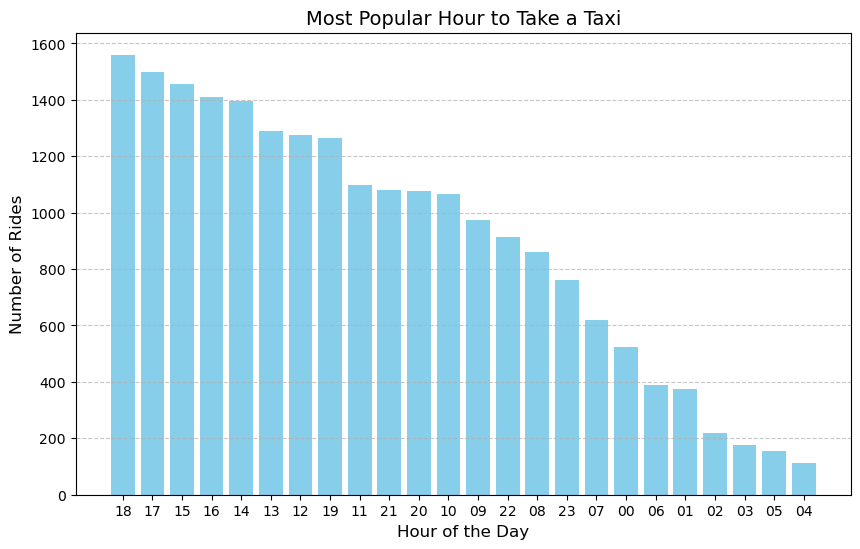

In [150]:
some_dataframe = get_data_for_visual_1()
plot_visual_1(some_dataframe)

### Visulization 2

In [153]:
def get_data_for_visual_2():
    query = """
    SELECT 
        strftime('%m', pickup_datetime) AS month,
        AVG(trip_distance) AS avg_distance,
        COUNT(*) AS total_trips
    FROM (
        SELECT 
            tpep_pickup_datetime AS pickup_datetime, 
            trip_distance 
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT 
            pickup_datetime, 
            trip_miles AS trip_distance 
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    )
    GROUP BY month
    ORDER BY month;
    """
    return pd.read_sql(query, con=engine)

In [155]:
def plot_visual_2_with_matplotlib(dataframe):
    dataframe['month'] = dataframe['month'].astype(int)
    dataframe = dataframe.sort_values(by='month')
    
    avg_distances = dataframe['avg_distance']
    sample_size = dataframe['total_trips']
    std_error = avg_distances.std() / (sample_size ** 0.5)  # Standard Error
    confidence = 0.90
    errors = t.ppf((1 + confidence) / 2, sample_size - 1) * std_error

    # Plot
    figure, ax = plt.subplots(figsize=(10, 6))
    ax.bar(dataframe['month'], avg_distances, yerr=errors, capsize=5, color='blue', alpha=0.7)
    ax.set_title("Average Distance Traveled per Month with 90% Confidence Interval", fontsize=14)
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel("Average Distance (Miles)", fontsize=12)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

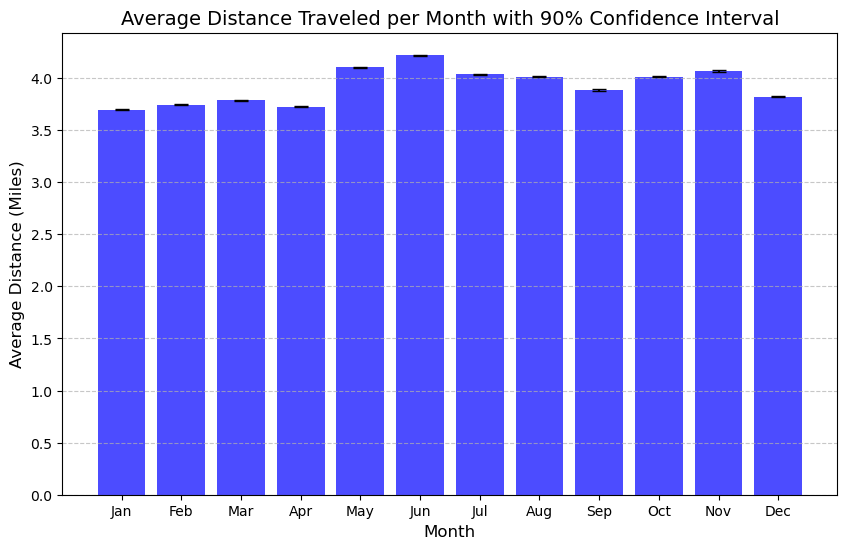

In [157]:
some_dataframe = get_data_for_visual_2()
plot_visual_2_with_matplotlib(some_dataframe)

### Visualization 3

In [160]:
def get_data_for_visual_3():
    query = """
    SELECT 
        strftime('%w', tpep_dropoff_datetime) AS day_of_week,
        COUNT(*) AS total_rides,
        CASE
            WHEN DOLocationID IN (1, 2, 3) THEN 'LGA'
            WHEN DOLocationID IN (4, 5, 6) THEN 'JFK'
            WHEN DOLocationID IN (7, 8, 9) THEN 'EWR'
            ELSE NULL
        END AS airport
    FROM taxi_trips
    WHERE tpep_dropoff_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY day_of_week, airport;
    """
    return pd.read_sql(query, con=engine)

In [162]:
def plot_visual_3(dataframe):
    # Convert day_of_week to readable format
    day_map = {
        '0': 'Sunday', '1': 'Monday', '2': 'Tuesday',
        '3': 'Wednesday', '4': 'Thursday', '5': 'Friday', '6': 'Saturday'
    }
    dataframe['day_of_week'] = dataframe['day_of_week'].astype(str).map(day_map)
    
    # Create the plot
    figure, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(
        data=dataframe,
        x='day_of_week', y='total_rides', hue='airport', ax=ax
    )
    ax.set_title("Most Popular Day for Airport Rides", fontsize=14)
    ax.set_xlabel("Day of the Week", fontsize=12)
    ax.set_ylabel("Number of Rides", fontsize=12)
    ax.legend(title="Airport")
    plt.show()

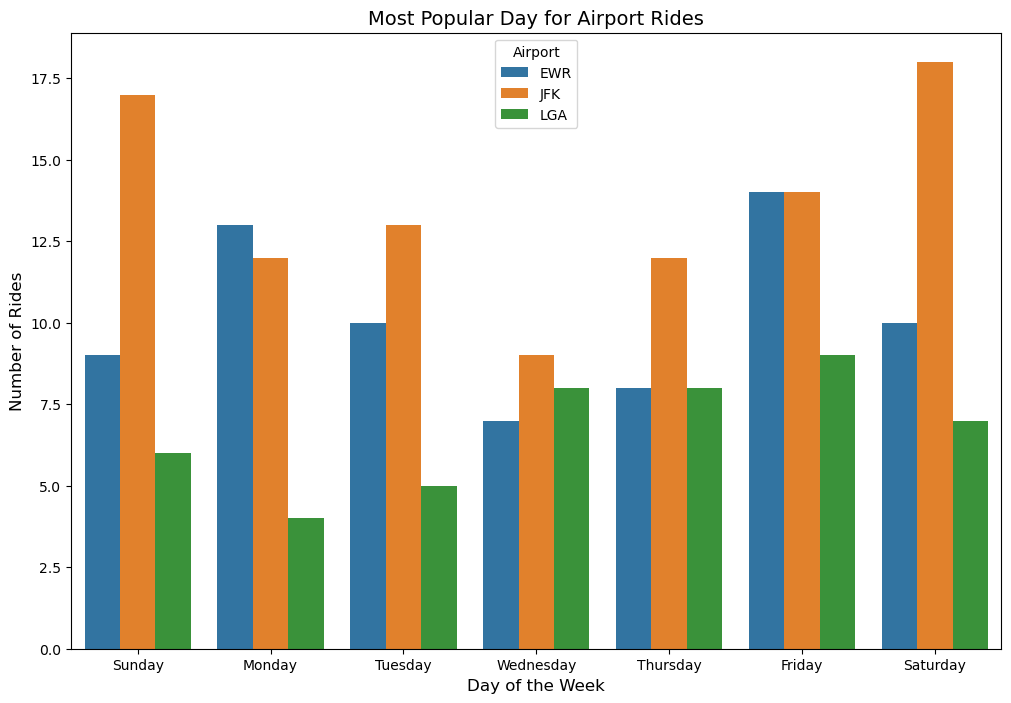

In [164]:
some_dataframe = get_data_for_visual_3()
plot_visual_3(some_dataframe)

### Visualization 4

In [167]:
def get_data_for_visual_4():
    query = """
    SELECT 
        strftime('%Y-%m', tpep_pickup_datetime) AS month,
        'Taxi' AS service,
        SUM(fare_amount + extra + mta_tax + tolls_amount + improvement_surcharge + congestion_surcharge) AS total_fare,
        SUM(fare_amount) AS base_fare,
        SUM(extra + improvement_surcharge + congestion_surcharge) AS surcharges,
        SUM(mta_tax) AS taxes,
        SUM(tolls_amount) AS tolls
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month
    
    UNION ALL
    
    SELECT 
        strftime('%Y-%m', request_datetime) AS month,
        'Uber' AS service,
        SUM(base_passenger_fare + tolls + bcf + sales_tax + congestion_surcharge + airport_fee) AS total_fare,
        SUM(base_passenger_fare) AS base_fare,
        SUM(bcf + congestion_surcharge + airport_fee) AS surcharges,
        SUM(sales_tax) AS taxes,
        SUM(tolls) AS tolls
    FROM uber_trips
    WHERE request_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month;
    """
    return pd.read_sql(query, con=engine)

In [169]:
def plot_visual_4(dataframe):
    # Convert 'month' to datetime format for proper sorting
    dataframe['month'] = pd.to_datetime(dataframe['month'], format='%Y-%m')

    # Separate data by service
    taxi_data = dataframe[dataframe['service'] == 'Taxi']
    uber_data = dataframe[dataframe['service'] == 'Uber']

    # Plot stacked bars
    figure, ax = plt.subplots(figsize=(14, 8))

    # Taxi fares
    ax.bar(taxi_data['month'], taxi_data['base_fare'], label='Taxi: Base Fare', width=20, align='center')
    ax.bar(taxi_data['month'], taxi_data['surcharges'], bottom=taxi_data['base_fare'], label='Taxi: Surcharges', width=20)
    ax.bar(taxi_data['month'], taxi_data['taxes'], bottom=taxi_data['base_fare'] + taxi_data['surcharges'], label='Taxi: Taxes', width=20)
    ax.bar(taxi_data['month'], taxi_data['tolls'], bottom=taxi_data['base_fare'] + taxi_data['surcharges'] + taxi_data['taxes'], label='Taxi: Tolls', width=20)

    # Uber fares
    ax.bar(uber_data['month'], uber_data['base_fare'], label='Uber: Base Fare', width=20, align='edge')
    ax.bar(uber_data['month'], uber_data['surcharges'], bottom=uber_data['base_fare'], label='Uber: Surcharges', width=20, align='edge')
    ax.bar(uber_data['month'], uber_data['taxes'], bottom=uber_data['base_fare'] + uber_data['surcharges'], label='Uber: Taxes', width=20, align='edge')
    ax.bar(uber_data['month'], uber_data['tolls'], bottom=uber_data['base_fare'] + uber_data['surcharges'] + uber_data['taxes'], label='Uber: Tolls', width=20, align='edge')

    # Set labels, title, and legend
    ax.set_title("Monthly Earned Total Fares by Service (January 2020 - August 2024)", fontsize=16)
    ax.set_xlabel("Month", fontsize=14)
    ax.set_ylabel("Total Fare ($)", fontsize=14)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Fare Breakdown")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

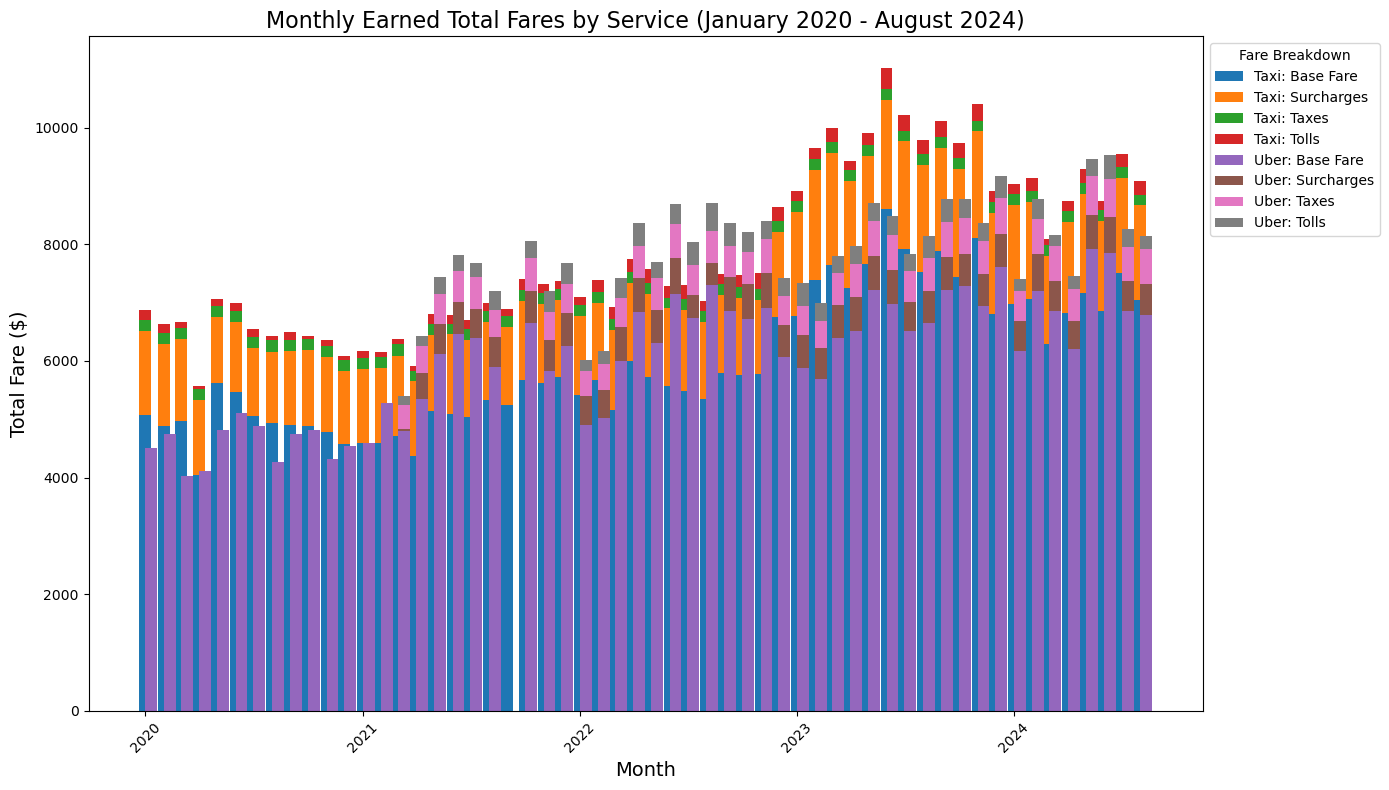

In [171]:
some_dataframe = get_data_for_visual_4()
plot_visual_4(some_dataframe)

### Visualization 5

In [556]:
def get_data_for_visual_5():
    query = """
    SELECT 
        trip_distance AS trip_distance, 
        tip_amount AS tip_amount, 
        DailyPrecipitation AS precipitation, 
        'Taxi' AS ride_type
    FROM 
        taxi_trips
    JOIN 
        daily_weather ON DATE(tpep_pickup_datetime) = daily_weather.DATE
    WHERE 
        tpep_pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31'
    UNION ALL
    SELECT 
        trip_miles AS trip_distance, 
        tips AS tip_amount, 
        DailyPrecipitation AS precipitation, 
        'Uber' AS ride_type
    FROM 
        uber_trips
    JOIN 
        daily_weather ON DATE(pickup_datetime) = daily_weather.DATE
    WHERE 
        pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31';
    """
    return pd.read_sql(query, con=engine)


In [558]:
def plot_visual_5(dataframe):
    taxi_data = dataframe[dataframe['ride_type'] == 'Taxi']
    uber_data = dataframe[dataframe['ride_type'] == 'Uber']

    figure, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Taxi: Distance vs Tip
    axes[0, 0].scatter(taxi_data['trip_distance'], taxi_data['tip_amount'], alpha=0.5, color='blue')
    axes[0, 0].set_title("Taxi: Distance vs Tip")
    axes[0, 0].set_xlabel("Trip Distance")
    axes[0, 0].set_ylabel("Tip Amount")

    # Uber: Distance vs Tip
    axes[0, 1].scatter(uber_data['trip_distance'], uber_data['tip_amount'], alpha=0.5, color='green')
    axes[0, 1].set_title("Uber: Distance vs Tip")
    axes[0, 1].set_xlabel("Trip Distance")
    axes[0, 1].set_ylabel("Tip Amount")

    # Taxi: Precipitation vs Tip
    axes[1, 0].scatter(taxi_data['precipitation'], taxi_data['tip_amount'], alpha=0.5, color='purple')
    axes[1, 0].set_title("Taxi: Precipitation vs Tip")
    axes[1, 0].set_xlabel("Precipitation")
    axes[1, 0].set_ylabel("Tip Amount")

    # Uber: Precipitation vs Tip
    axes[1, 1].scatter(uber_data['precipitation'], uber_data['tip_amount'], alpha=0.5, color='orange')
    axes[1, 1].set_title("Uber: Precipitation vs Tip")
    axes[1, 1].set_xlabel("Precipitation")
    axes[1, 1].set_ylabel("Tip Amount")

    plt.tight_layout()
    plt.show()

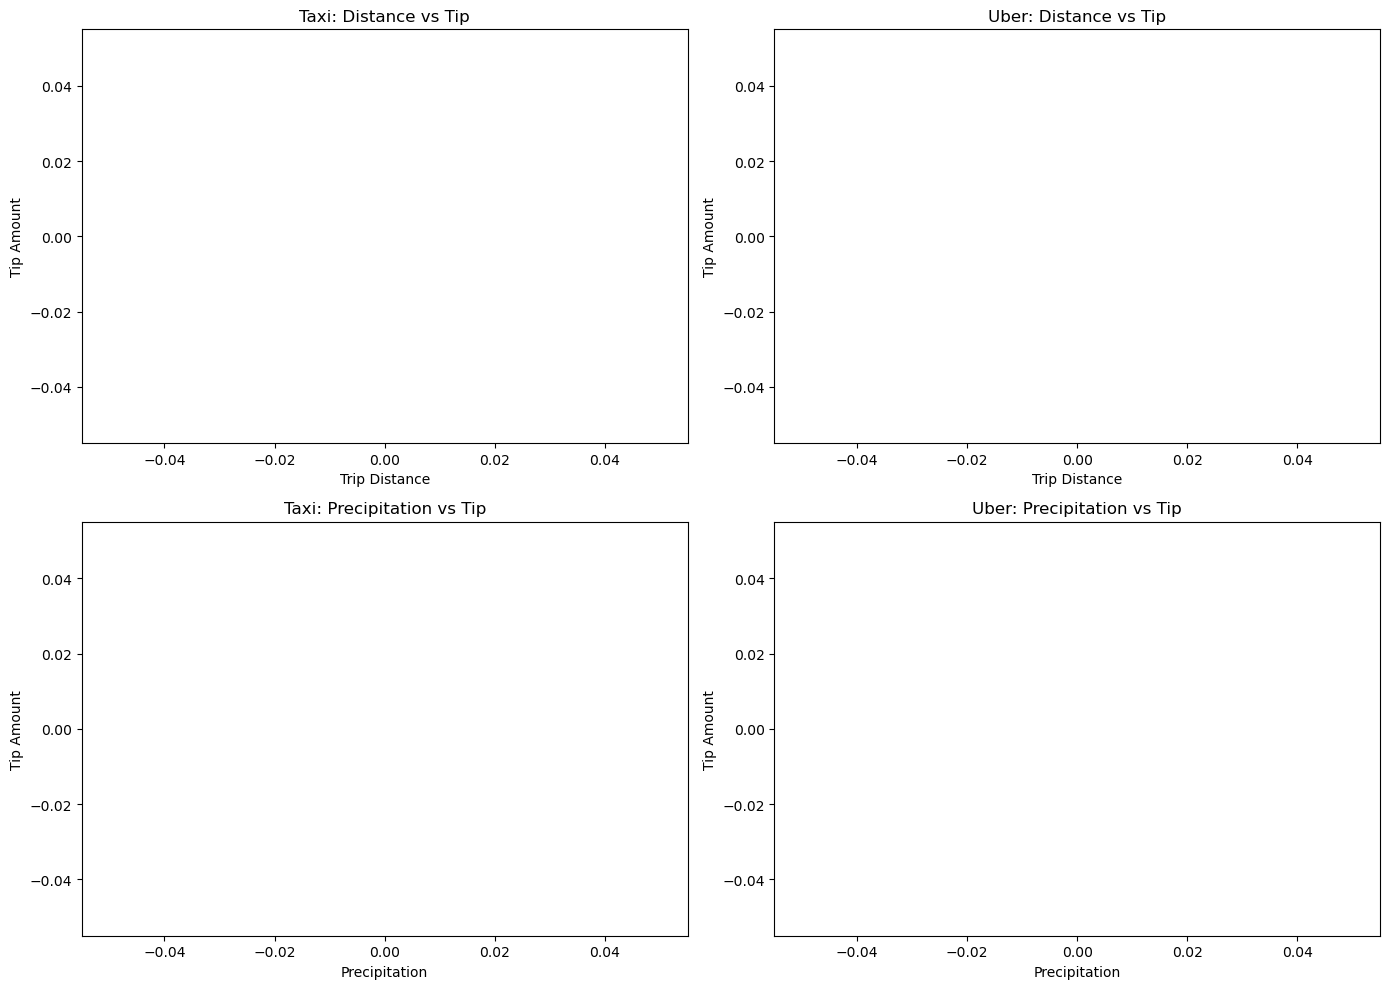

In [560]:
some_dataframe = get_data_for_visual_5()
plot_visual_5(some_dataframe)

In [562]:
query = """
SELECT COUNT(*)
FROM taxi_trips
JOIN daily_weather ON DATE(tpep_pickup_datetime) = daily_weather.DATE
WHERE tpep_pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31';
"""
result = pd.read_sql(query, con=engine)
print(result)

   COUNT(*)
0         0


### Visualization 6

In [209]:
from sqlalchemy import create_engine

# 创建数据库连接
engine = create_engine("sqlite:///project.db")

# 检查数据库中的所有表
with engine.connect() as connection:
    result = connection.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [row[0] for row in result]
    print("数据库中的表:", tables)

# 检查每个表的结构
for table in tables:
    print(f"\n表 {table} 的结构:")
    with engine.connect() as connection:
        result = connection.execute(f"PRAGMA table_info({table});")
        for row in result:
            print(row)


ObjectNotExecutableError: Not an executable object: "SELECT name FROM sqlite_master WHERE type='table';"

In [205]:
def get_data_for_visual_6():
    query = """
    SELECT
        location_lookup.longitude AS lon,
        location_lookup.latitude AS lat
    FROM taxi_trips
    JOIN location_lookup
    ON taxi_trips.PULocationID = location_lookup.location_id
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
    UNION ALL
    SELECT
        location_lookup.longitude AS lon,
        location_lookup.latitude AS lat
    FROM uber_trips
    JOIN location_lookup
    ON uber_trips.PULocationID = location_lookup.location_id
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31';
    """
    try:
        dataframe = pd.read_sql(query, con=engine)
        print(f"Data loaded successfully! Rows fetched: {len(dataframe)}")
        return dataframe
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [197]:
def plot_visual_6(dataframe):
    if dataframe is None or dataframe.empty:
        print("No data to plot.")
        return

    heat_data = dataframe[['lat', 'lon']].dropna()

    if heat_data.empty:
        print("No valid coordinates found.")
        return

    base_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
    HeatMap(data=heat_data.values.tolist(), radius=8).add_to(base_map)
    base_map.save("heatmap_2020.html")
    print("Heatmap saved as 'heatmap_2020.html'.")

In [199]:
some_dataframe = get_data_for_visual_6()
plot_visual_6(some_dataframe)

Error fetching data: (sqlite3.OperationalError) no such table: location_lookup
[SQL: 
    SELECT
        location_lookup.longitude AS lon,
        location_lookup.latitude AS lat
    FROM taxi_trips
    JOIN location_lookup
    ON taxi_trips.PULocationID = location_lookup.location_id
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
    UNION ALL
    SELECT
        location_lookup.longitude AS lon,
        location_lookup.latitude AS lat
    FROM uber_trips
    JOIN location_lookup
    ON uber_trips.PULocationID = location_lookup.location_id
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31';
    ]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
No data to plot.
